<a href="https://colab.research.google.com/github/elliemci/agents/blob/main/design_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow Design

Build a workflow to create a custome multi-agent system with:
* **Fine-grained flow control**: how the data gets passed around the system: looping, branching parallel calls and map-reduce behavior
* **Reflection** agents examine their own output
* **Structured inputs** and outouts: a richer than a string inputs and outputs
* **Multimodality**: handling images, audio and video
* **Query planning**: complex planning of how to run based on its inputs

## Installs and Setup

In [ ]:
!pip install llama_index

In [ ]:
!pip install tavily-python

In [ ]:
!pip install llama-index-llms-huggingface-api

In [ ]:
!pip install llama-index llama-index-llms-openai

In [6]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/AgentsCourse

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/AgentsCourse


In [26]:
from google.colab import userdata
from huggingface_hub import login
from llama_index.llms.openai import OpenAI
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI

hf_hub_token = userdata.get('huggingface_hub_access_token')
login(token=hf_hub_token)
tavily_api_key = userdata.get('TAVILY_API_KEY')
openai_api_key = userdata.get('OPENAI_API_KEY')

# instantiating an LLM
llm = HuggingFaceInferenceAPI(model_name="Qwen/Qwen2.5-Coder-32B-Instruct")
#llm = OpenAI(model="gpt-4o-mini", api_key=openai_api_key)

## Basic Workflow

`Workflows` are regular python clases, defined as a series of steps, each of which receices certain classes of events and emits certain classes of events.

### Tools

In [8]:
from llama_index.core.workflow import StartEvent, StopEvent, Workflow, step
from tavily import AsyncTavilyClient

In [9]:
class SimpleWorkflow(Workflow):
  @step
  async def first_step(self, ev: StartEvent) -> StopEvent:
    # do  something
    return StopEvent(result="Executing step 1 is done successfully!")

workflow = SimpleWorkflow(timeout=10, verbose=True)
result = await workflow.run()
print(result)

Running step first_step
Step first_step produced event StopEvent
Executing step 1 is done successfully!


## Multi-step workflow

In [29]:
from openai import OpenAI

client = OpenAI(api_key=openai_api_key)

async def web_search(query: str) -> str:
  """Useful for searching the web and feting data on agiven topic or question."""
  client = AsyncTavilyClient(api_key=tavily_api_key)
  response = await client.search(query)
  return str(response) # conver response to a string for processing

async def summarize_text_gpt(text: str, model: str = "gpt-3.5-turbo") -> str:
    """Summarizes text using OpenAI's GPT API."""
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "Summarize the following research data:"},
                {"role": "user", "content": text}
            ],
            temperature=0.5,
            max_tokens=150
        )
        # Correct way to access response content
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error in GPT summarization: {e}"



Steps are created by custom events that inherit from Event clas that can be emitted and triger other steps.

In [31]:
from llama_index.core.workflow import StartEvent, StopEvent, Workflow, step, Event
from llama_index.utils.workflow import draw_all_possible_flows

# define custom events
class SearchEvent(Event):
    first_output: str
    input_data: dict


class GetDataEvent(Event):
    second_output: str
    input_data: dict


class SummaryDataWorkflow(Workflow):
    @step
    async def first_step(self, ev: StartEvent) -> SearchEvent:
        """Initial step to gather research topic and start web search."""
        research_topic = ev.input_data.get("topic", "latest stockmarket news")
        print(f"Starting research on: {research_topic}")
        return SearchEvent(first_output=research_topic, input_data={"topic": research_topic})

    @step
    async def fetch_research_data(self, ev: SearchEvent) -> GetDataEvent:
        """Fetch research data using Tavily Web Search."""
        topic = ev.input_data["topic"]
        print(f"Searching the web for {topic}")
        research_data = await web_search(topic)
        print(ev.first_output)
        print(f"Web search results received: {research_data[:500]}")
        return GetDataEvent(second_output=research_data, input_data={"topic": topic})

    @step
    async def process_research_data(self, ev: GetDataEvent) -> StopEvent:
        """Summarizes research data."""
        topic = ev.input_data["topic"]
        data = ev.second_output
        print("Summarizing research data ...")
        summary = await summarize_text_gpt(data)
        print(f"Summary preview: {summary[:500]} ...")
        return StopEvent(result={"topic": topic, "summary": summary})


# Instantiate and run the workflow
workflow = SummaryDataWorkflow(timeout=30, verbose=True)
result = await workflow.run(input_data={"topic": "Latest AI breakthroughs"})
print()
print("Final Result:", result['summary'])


Running step first_step
Starting research on: Latest AI breakthroughs
Step first_step produced event SearchEvent
Running step fetch_research_data
Searching the web for Latest AI breakthroughs
Latest AI breakthroughs
Web search results received: {'query': 'Latest AI breakthroughs', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Latest AI Breakthroughs and News - February 2025 | News', 'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates', 'content': 'Summary: OpenAI has announced GPT-4.5, its largest and most advanced AI model to date. Summary: Interview Kickstart has introduced a new Generative AI (GenAI) course designed for professionals aiming to enhance their skills in artificial intell
Step fetch_research_data produced event GetDataEvent
Running step process_research_data
Summarizing research data ...
Summary preview: The research data highlights several recent AI breakthroughs and advancements. OpenAI introduced GPT-4.5, its most adva

### Visualiztion

A built-in visualizer, created a interactive html file in current directory

In [ ]:
!pip install llama-index-utils-workflow

In [32]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(workflow, filename="simple_workflow.html")

<class 'NoneType'>
<class '__main__.GetDataEvent'>
<class '__main__.SearchEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
simple_workflow.html


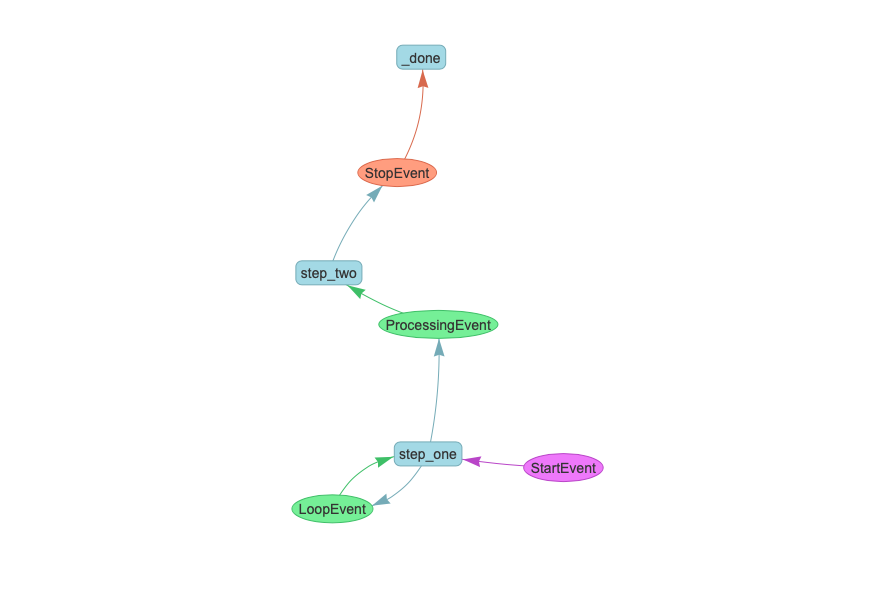

In [36]:
from IPython.display import Image, IFrame, display
Image('workflow.png')
